In [1]:
import numpy as np
import pandas as pd
from os.path import join
from os import listdir
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

import glambox as gb

%load_ext autoreload
%autoreload 2

In [2]:
estimates = pd.read_csv('resources/individual_estimates_sec_nhb2019.csv')
estimates.head()

,subject,dataset,v,gamma,s,tau
0,0,krajbich2010,0.836589,0.753474,0.330188,0.533923
1,1,krajbich2010,0.941252,-0.088221,0.312674,0.245130
2,2,krajbich2010,0.237037,0.737735,0.324341,2.273200
3,3,krajbich2010,0.889059,0.455739,0.199640,0.097201
4,4,krajbich2010,0.882176,0.500506,0.321229,0.367597


# Summary dataframe

In [3]:
estimates_long = pd.melt(estimates,
                         id_vars=['dataset', 'subject'],
                         value_vars=['v', 'gamma', 's', 'tau'],
                         var_name='parameter',
                         value_name='estimate')

summary = estimates_long.groupby(['dataset', 'parameter'])['estimate'].describe()
summary.to_csv('si/individual_estimates_nhb2019_summary.csv')
summary

count      mean       std       min       25%  \
dataset      parameter                                                  
folke2016    gamma       24.0 -0.011541  0.275184 -0.447339 -0.223694   
             s           24.0  0.187753  0.033058  0.119082  0.170898   
             tau         24.0  1.848287  0.966956  0.428721  1.190455   
             v           24.0  0.250486  0.080398  0.168045  0.190530   
krajbich2010 gamma       39.0  0.226243  0.469546 -0.782339 -0.069287   
             s           39.0  0.281198  0.050968  0.194893  0.247995   
             tau         39.0  0.735433  0.524953  0.097201  0.365910   
             v           39.0  0.772557  0.332153  0.237037  0.525456   
krajbich2011 gamma       30.0  0.194018  0.409058 -1.016239 -0.072905   
             s           30.0  0.251376  0.048122  0.167304  0.217025   
             tau         30.0  0.996675  0.709580  0.236791  0.516007   
             v           30.0  0.669702  0.330017  0.179730  0.444843   
tavares2017  gamma       25.0  0.085439  0.227672 -0.357611  0.011324   
             s           25.0  0.371197  0.054404  0.226857  0.351090   
             tau         25.0  0.538541  0.257301  0.118894  0.343985   
             v           25.0  0.837311  0.298769  0.382806  0.544324   

                             50%       75%       max  
dataset      parameter                                
folke2016    gamma     -0.043663  0.200627  0.427321  
             s          0.185912  0.207563  0.275464  
             tau        1.618128  2.524970  3.922530  
             v          0.224431  0.302070  0.513506  
krajbich2010 gamma      0.330616  0.598846  0.849326  
             s          0.289897  0.316952  0.384306  
             tau        0.565114  1.090331  2.273200  
             v          0.772084  0.929638  1.688619  
krajbich2011 gamma      0.325934  0.454795  0.814595  
             s          0.247268  0.280711  0.360841  
             tau        0.811382  1.388484  3.528217  
             v          0.625911  0.784642  1.581185  
tavares2017  gamma      0.082989  0.217748  0.543590  
             s          0.367335  0.391687  0.460543  
             tau        0.492204  0.741303  0.971113  
             v          0.902292  1.024836  1.395963

# Illustrate individual model estimates from NHB 2019

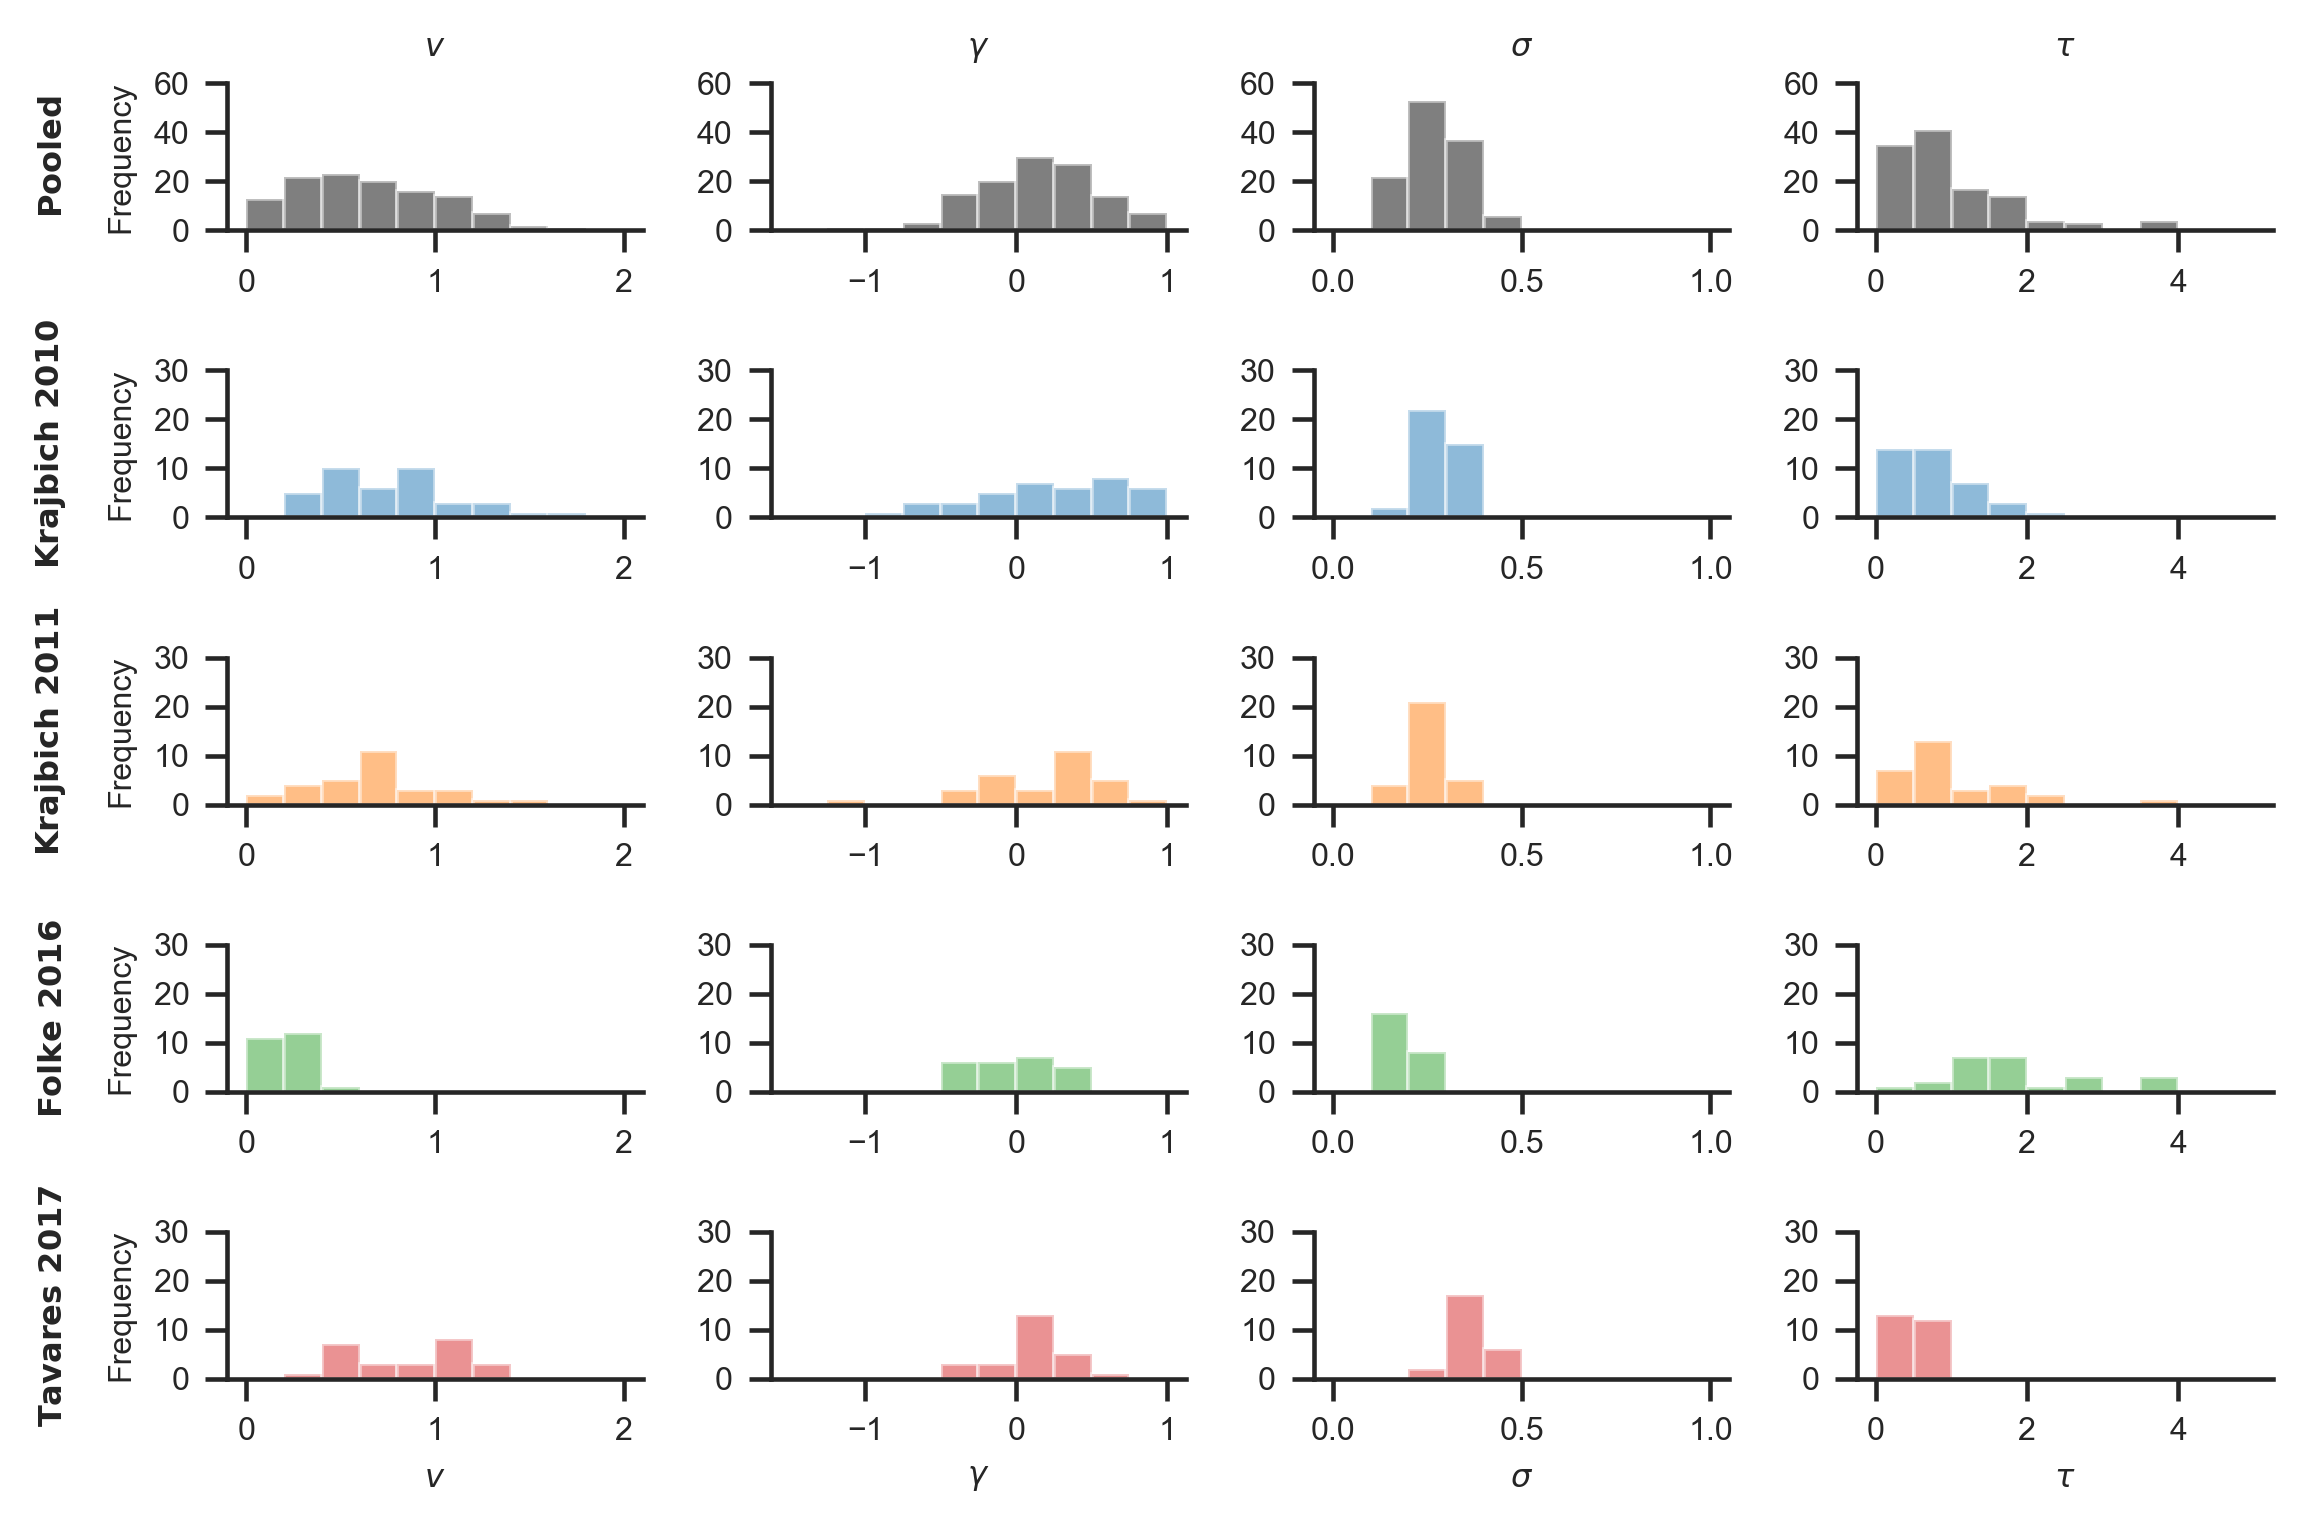

In [4]:
parameters = ['v', 'gamma', 's', 'tau']
parameter_names = dict(v=r'$v$',
                       gamma=r'$\gamma$',
                       s=r'$\sigma$',
                       tau=r'$\tau$')
limits = dict(v=(0, 2),
              gamma=(-1.5, 1),
              s=(0, 1),
              tau=(0, 5))
fontsize = 7
n_bins = 10

datasets = estimates['dataset'].unique()

fig, axs = plt.subplots(len(datasets) + 1,
                        len(parameters),
                        figsize=(gb.plots.cm2inch(18, 12)),
                        dpi=330,
                        sharex='col',
                        sharey='row')

for p, parameter in enumerate(parameters):
    bins = np.linspace(*limits[parameter], n_bins + 1)
    
    # Pooled
    axs[0, p].set_title(parameter_names[parameter], fontsize=fontsize)
    axs[0, p].hist(estimates.loc[:, parameter],
                   bins=bins,
                   color='black',
                   alpha=0.5,
                   edgecolor='white')
    axs[0, p].set_yticks(range(0, 61, 20))
    axs[0, p].set_ylim(0, 60)
    if p == 0:
        axs[0, p].set_ylabel(r'$\bf{Pooled}$' + '\n\nFrequency', fontsize=fontsize)

    for d, dataset in enumerate(datasets):
        dataset_str = dataset[:-4].capitalize() + '~' + dataset[-4:]
        if p == 0:
            axs[d + 1, 0].set_ylabel(r'$\bf{{{dataset}}}$'.format(dataset=dataset_str) + '\n\nFrequency',
                                     fontsize=fontsize)
        axs[d + 1, p].hist(
            estimates.loc[estimates['dataset'] == dataset, parameter],
            alpha=0.5,
            edgecolor='white',
            bins=bins,
            color='C{}'.format(d),
            density=False)
        axs[d + 1, p].set_yticks(range(0, 31, 10))
        axs[d + 1, p].set_ylim(0, 30)
        if (d + 1) == len(datasets):
            axs[d + 1, p].set_xlabel(parameter_names[parameter], fontsize=fontsize)

for ax in axs.ravel():
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelbottom=True)

fig.tight_layout()
sns.despine()
plt.savefig('si/individual_estimates_nhb2019.png', dpi=330)

# Visualize (hyper)priors implemented in the model

In [5]:
precision = dict(v=3, s=3, gamma=3, tau=3)

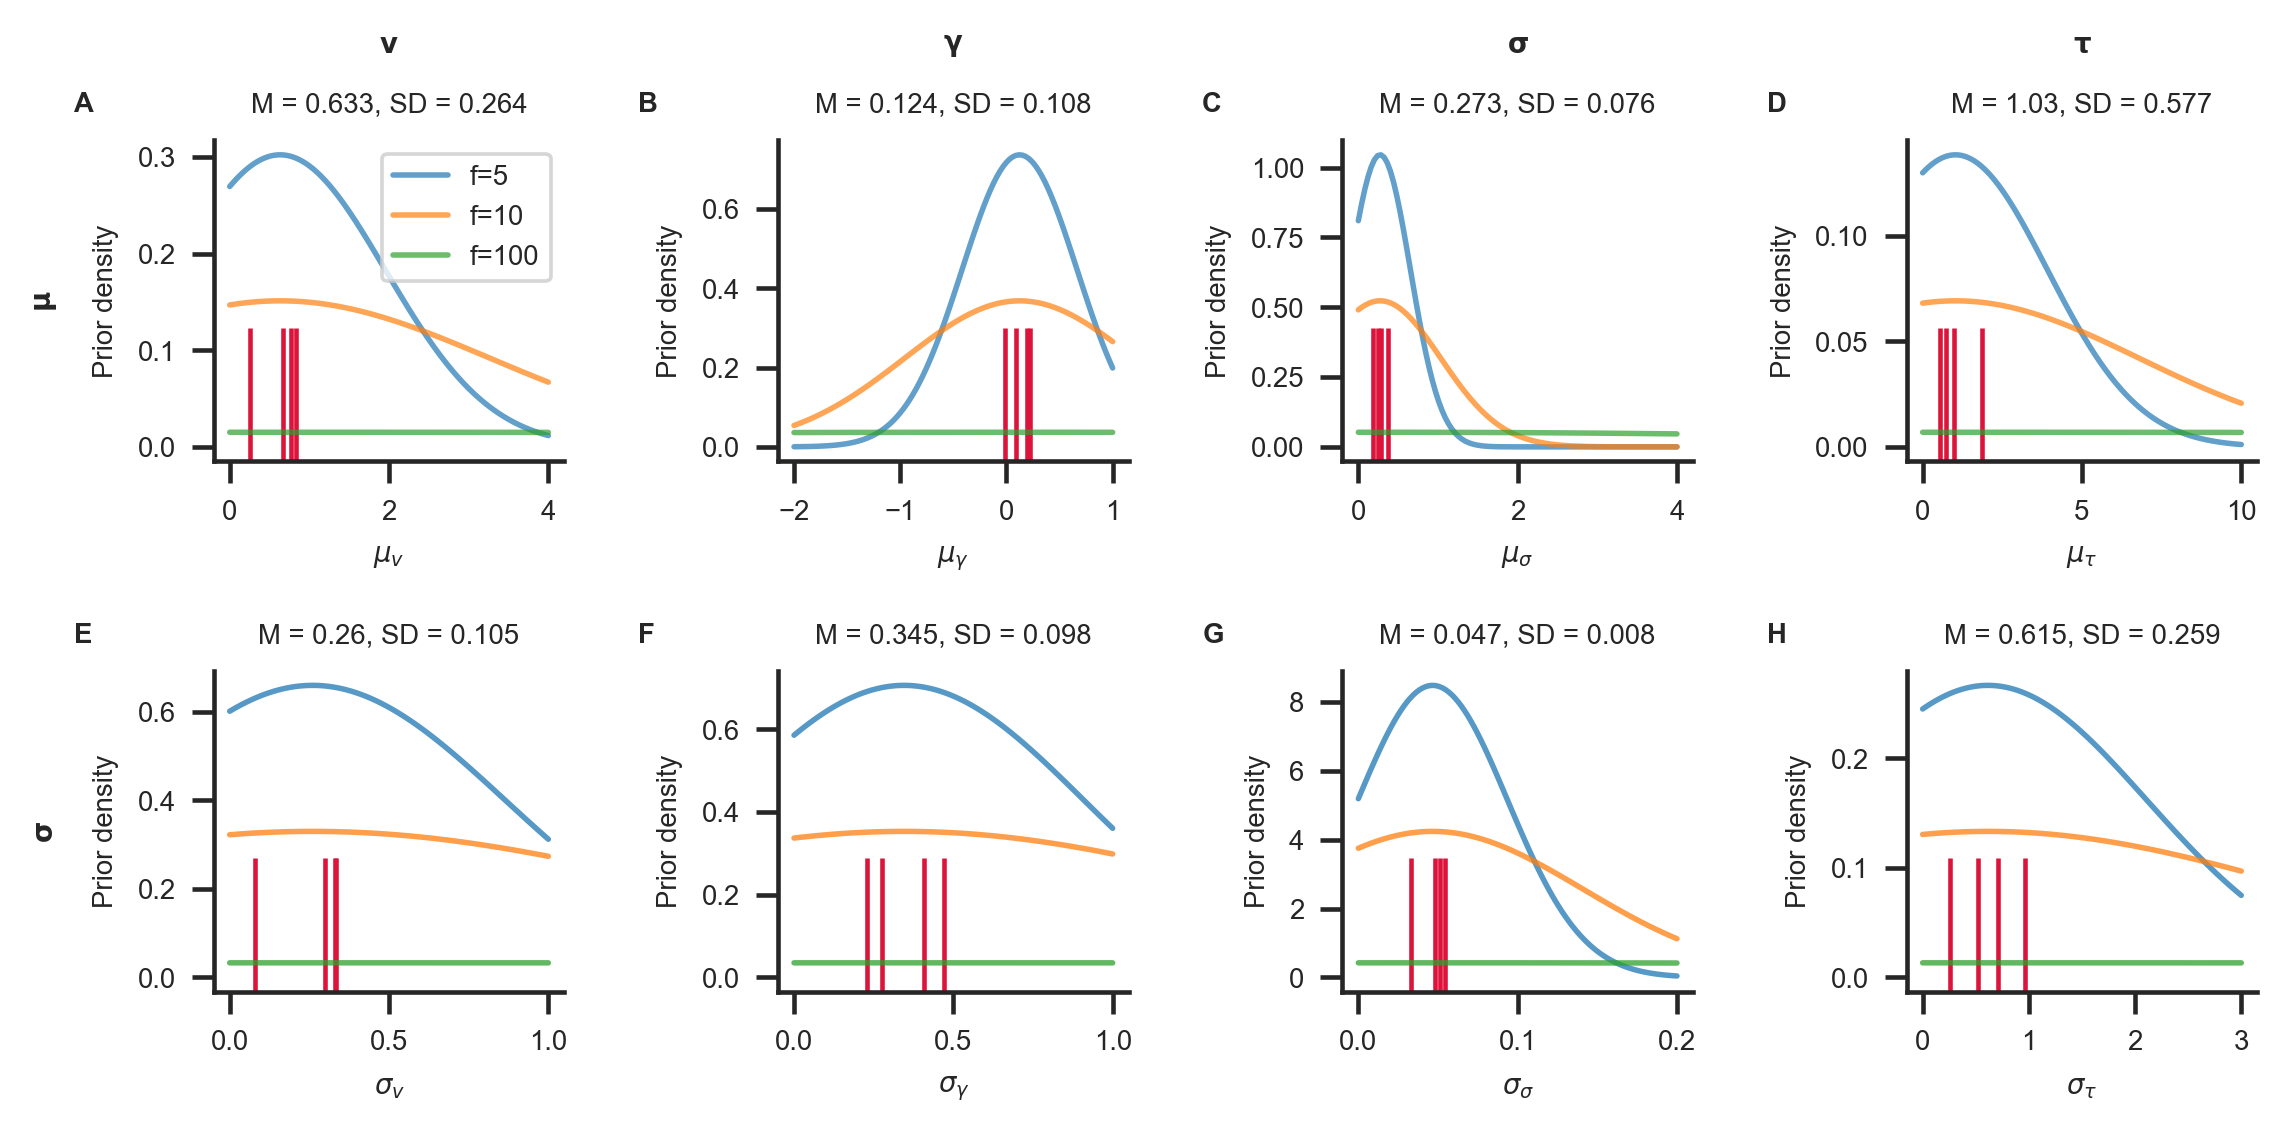

In [6]:
fontsize = 6
fs = [5, 10, 100]

parameters = ['v', 'gamma', 's', 'tau']
parameter_labels = dict(v='v', gamma='\gamma', s='\sigma', tau='\\tau')

bounds = dict(v=dict(mu=(0, 4),
                     sd=(0, 1)),
              gamma=dict(mu=(-2, 1),
                         sd=(0, 1)),
              s=dict(mu=(0, 4),
                     sd=(0, 0.2)),
              tau=dict(mu=(0, 10),
                       sd=(0, 3)))

from scipy.stats import norm

n_params = len(parameters)

fig, axs = plt.subplots(2, n_params, figsize=gb.plots.cm2inch(18, 9), dpi=330)

for p, parameter in enumerate(parameters):

    # Observed group level parameters from NHB 2019 datasets
    ## Mean
    means = estimates.groupby('dataset')[parameter].mean()
    axs[0, p].plot(means,
                   np.zeros(len(means)),
                   '|',
                   color='crimson',
                   markersize=52)
    axs[0, p].set_title(r'$\bf{{{p}}}$'.format(p=parameter_labels[parameter]) +
                        '\n\nM = {}, SD = {}'.format(
                            np.round(means.mean(), precision[parameter]),
                            np.round(means.std(), precision[parameter])),
                        fontsize=fontsize)
    axs[0, p].set_xlabel(r'$\mu_{}$'.format(parameter_labels[parameter]),
                         fontsize=fontsize)
    if p == 0:
        axs[0, p].set_ylabel(r'$\bf{\mu}$' + '\n\nPrior density',
                             fontsize=fontsize)
    else:
        axs[0, p].set_ylabel('Prior density', fontsize=fontsize)

    ## SD
    sds = estimates.groupby('dataset')[parameter].std()
    axs[1, p].plot(sds,
                   np.zeros(len(sds)),
                   '|',
                   color='crimson',
                   markersize=52)
    axs[1, p].set_title('\n\nM = {}, SD = {}'.format(
        np.round(np.mean(sds), precision[parameter]),
        np.round(np.std(sds), precision[parameter])),
                        fontsize=fontsize)

    axs[1, p].set_xlabel(r'$\sigma_{}$'.format(parameter_labels[parameter]),
                         fontsize=fontsize)
    if p == 0:
        axs[1, p].set_ylabel(r'$\bf{\sigma}$' + '\n\nPrior density',
                             fontsize=fontsize)
    else:
        axs[1, p].set_ylabel('Prior density', fontsize=fontsize)


    # Construct priors
    mu_mean = means.mean()  # Mean of prior for group mean is the mean over observed group means
    mu_sd = means.std()     # SD of prior for group mean is the SD over observed group means (times f)
    sd_mean = sds.mean()    # Mean of prior for group SD is the mean over observed group SDs
    sd_sd = sds.std()       # SD of prior for group SD is the SD over observed group SDs (times f)
    
    for i, f in enumerate(fs):

        x_mu = np.linspace(*bounds[parameter]['mu'], 100)
        axs[0, p].plot(x_mu,
                       norm.pdf(x_mu,
                                loc=mu_mean,
                                scale=f*mu_sd),
                       color='C{}'.format(i),
                       alpha=0.7,
                       label='f={}'.format(f))
        x_sd = np.linspace(*bounds[parameter]['sd'], 100)
        axs[1, p].plot(x_sd,
                       norm.pdf(x_sd,
                                loc=sd_mean,
                                scale=f*sd_sd),
                       color='C{}'.format(i),
                       alpha=0.75,
                       label='f={}'.format(f))

# Legend
axs[0, 0].legend(fontsize=fontsize)
        
# Panel Labels
from string import ascii_uppercase
for label, ax in zip(list(ascii_uppercase), axs.ravel()):
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.text(-0.4,
            1.15,
            label,
            transform=ax.transAxes,
            fontsize=fontsize,
            fontweight='bold',
            va='top')

for ax in axs.ravel():
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

sns.despine()
fig.tight_layout(h_pad=-0.2, w_pad=1.2)
plt.savefig(join('si', 'hyperpriors.png'), dpi=330)